In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import colorcet as cc
import plotly.express as px

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%matplotlib inline

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'newplot',
    'height': 500,
    'width': 900,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

In [14]:
df=pd.read_pickle('./dataset_/dataset_cleaned_popularity.pkl')
df.drop(columns=['index', 'level_0'], inplace=True)  # Comes from pickeling the file
df.reset_index(drop=True, inplace=True)

In [15]:
df['popularity'].describe()

count    166681.000000
mean       5511.366120
std       13236.831027
min           0.800000
25%          78.400000
50%         530.400000
75%        3995.050000
max      233766.900000
Name: popularity, dtype: float64

## Popularity Prediction
This week, we started to work on our predictive mining tasks, one of them is song popularity prediction. By the end of this project, we hope that we can see what is the typical song that is getting more popular than the others in Spotify. We got two ideas in mind, which are popularity score prediction and popularity classification (popular / not popular).

### Data Pre-processing
Before jump into the main modelling task, here we'll process all of our our possible features based on its data type:

**Numerical Features**
* popularity
* artist_followers
* danceability
* energy
* loudness
* speechiness
* acoustics
* instrumentalness
* liveness
* valence
* duration_min

**Categorical Features**
* explicit
* key
* release_day

For the first round selection, we selected the features based on our knowledge and common sense, later we'll do the feature selection based on how each of them perform in some evaluation measurement or algorithm.
#### Popularity
The original value of our popularity score is the calculation of number of days and position they stayed in the Top 200 Playlist and the score is also difference for each country.

In [16]:
df.sort_values(by='popularity', ascending=False).head(5)

,country,uri,popularity,title,artist,release_type,sub_genre,artist_followers,explicit,album,release_date,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,days_since_release,released_after_2017,explicit_false,explicit_true,popu_max,top10_dummy,top50_dummy,cluster,duration_min,release_year,release_month,release_day
52226,Belgium,https://open.spotify.com/track/7qiZfU4dY1lWllz...,233766.9,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3
52232,Costa Rica,https://open.spotify.com/track/7qiZfU4dY1lWllz...,228707.2,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,spanish speaking,3.895217,2017,3,3
52220,Global,https://open.spotify.com/track/7qiZfU4dY1lWllz...,221571.0,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,global,3.895217,2017,3,3
30287,Philippines,https://open.spotify.com/track/5uCax9HTNlzGybI...,217605.8,say you wont let go,James Arthur,album,pop,6843219.0,False,Back from the Edge,2016-10-28,2,17,0.358,0.557,10,-7.398,1,0.0590,0.695,0.0,0.0902,0.494,85.043,4,pop,1469.0,0.0,1,0,2,1.0,1.0,southern europe and portuguese heritage,3.524450,2016,10,28
52252,Singapore,https://open.spotify.com/track/7qiZfU4dY1lWllz...,217307.4,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),2017-03-03,4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.0,0.0931,0.931,95.977,4,pop,1349.0,1.0,1,0,1,1.0,1.0,english speaking and nordic,3.895217,2017,3,3


As you can see in the table, there are multiple countries that have "Shape of You" as their top popular song, and this also means that this song is very popular compared to a song that only appears in one coutnry top playlist, right?

So, in order to get a unique song popularity score, we decided to sum up the every country's popularity score for each song, since the higher value they got, means the more popular they are.

In [17]:
df = df.groupby(['title', 'artist', 'release_type', 'sub_genre', 'artist_followers', 'explicit', 'album', 'track_number', 'tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genre', 'duration_min', 'release_year', 'release_month', 'release_day'])['popularity'].sum().reset_index(name='popularity')
df.sort_values(by='popularity', ascending=False).head(5)

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity
44367,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),4,16,0.825,0.652,1,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,4,pop,3.895217,2017,3,3,5732932.35
11089,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,1,1,0.825,0.593,6,-6.401,0,0.0988,0.688,0.000161,0.1700,0.540,98.078,4,pop,3.495917,2019,5,10,3624590.65
38669,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),5,16,0.599,0.448,8,-6.312,1,0.0232,0.163,0.000000,0.1060,0.168,95.050,3,pop,4.390000,2017,3,3,2933691.50
4480,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2,14,0.701,0.425,7,-10.965,1,0.3750,0.328,0.130000,0.1000,0.562,135.128,4,pop,3.234800,2019,3,29,2812179.25
44341,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,12,34,0.572,0.385,7,-6.362,1,0.0308,0.371,0.000000,0.2310,0.323,95.799,4,pop,3.595550,2018,10,5,2600171.85


As a result, we got 59,492 unique songs. Then, we tried to visualize the distribution, but it turned out that the final popularity score is too large and not easily readable. Thus, we normalized the value to a 0-100 range to make it similar with the popularity score calculated by Spotify

In [18]:
df['popularity'] = (df['popularity'] - df['popularity'].min()) / (df['popularity'].max() - df['popularity'].min()) * 100

In [19]:
df.sort_values(by='popularity', ascending=False).head(10)

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity
44367,shape of you,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),4,16,0.825,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,4,pop,3.895217,2017,3,3,100.000000
11089,dance monkey,Tones And I,single,australian pop,2283019.0,False,Dance Monkey,1,1,0.825,0.593,6,-6.401,0,0.0988,0.68800,0.000161,0.1700,0.540,98.078,4,pop,3.495917,2019,5,10,63.224021
38669,perfect,Ed Sheeran,album,pop,71783101.0,False,÷ (Deluxe),5,16,0.599,0.448,8,-6.312,1,0.0232,0.16300,0.000000,0.1060,0.168,95.050,3,pop,4.390000,2017,3,3,51.172610
4480,bad guy,Billie Eilish,album,electropop,34697267.0,False,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2,14,0.701,0.425,7,-10.965,1,0.3750,0.32800,0.130000,0.1000,0.562,135.128,4,pop,3.234800,2019,3,29,49.053062
44341,shallow,Lady Gaga - Bradley Cooper,album,dance pop,14439685.0,False,A Star Is Born Soundtrack,12,34,0.572,0.385,7,-6.362,1,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4,pop,3.595550,2018,10,5,45.354999
45968,someone you loved,Lewis Capaldi,album,pop,5649718.0,False,Divinely Uninspired To A Hellish Extent,4,12,0.501,0.405,1,-5.679,1,0.0319,0.75100,0.000000,0.1050,0.446,109.891,4,pop,3.036017,2019,5,17,43.638799
44304,señorita,Shawn Mendes - Camila Cabello,album,canadian pop,29743681.0,False,Shawn Mendes (Deluxe),1,16,0.759,0.548,9,-6.049,0,0.0290,0.03920,0.000000,0.0828,0.749,116.967,4,pop,3.180000,2019,6,19,43.184823
34452,new rules,Dua Lipa,album,dance pop,20575026.0,False,Dua Lipa (Deluxe),10,17,0.762,0.700,9,-6.021,0,0.0694,0.00261,0.000016,0.1530,0.608,116.073,4,pop,3.488667,2017,6,2,42.167052
11936,despacito - remix,Luis Fonsi - Daddy Yankee - Justin Bieber,single,latin,8932627.0,False,Despacito Feat. Justin Bieber (Remix),1,1,0.694,0.815,2,-4.328,1,0.1200,0.22900,0.000000,0.0924,0.813,88.931,4,latin,3.813783,2017,4,17,41.524686
45990,something just like this,The Chainsmokers - Coldplay,album,dance pop,16931568.0,False,Memories...Do Not Open,5,12,0.617,0.635,11,-6.769,0,0.0317,0.04980,0.000014,0.1640,0.446,103.019,4,pop,4.119333,2017,4,7,41.099031


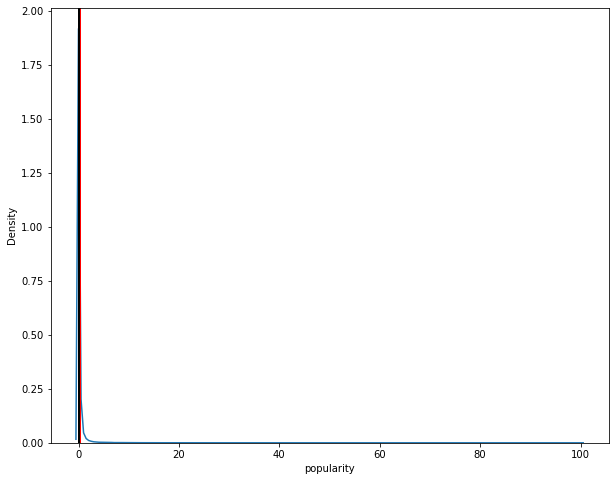

In [20]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

In [21]:
df['popularity'].describe()

count    59492.000000
mean         0.269332
std          1.539976
min          0.000000
25%          0.001619
50%          0.010614
75%          0.081869
max        100.000000
Name: popularity, dtype: float64

In [22]:
df[df['popularity'] <= 0.269332]['popularity'].count()

51487

In [23]:
df[df['popularity'] > 0.269332]['popularity'].count()

8005

In [24]:
df[df['popularity'] <= 0.010614]['popularity'].count()

29745

In [25]:
df[df['popularity'] > 0.010614]['popularity'].count()

29747

The mean is way too shifted to the right, even from 59k songs, 51k songs are below average, because there are a few outlier songs. To get a normal distribution, we have to enrich the data with higher popularity score songs or remove outliers. The first option is not possible since the popularity calculation in our dataset is made by the author not Spotify, so if we download new data from spotify, the meaning of popularity score will be different. Therefore, we'll try to model our data as it is for now, and if the result is not good enough then we'll try remove some outliers.

In [42]:
#df.drop(df[df['popularity'] > 0.005].index, inplace = True)